In [1]:
import random

In [2]:
import cv2

In [3]:
import time

In [4]:
import pyautogui

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
import pytesseract

# Utility functions

In [9]:
def take_screen_shot(region=None):
    """
    region: four-integer tuple of the left, top,
    width, and height of the region to capture
    """
    
    print('Waiting 5 seconds before screen shot')
    print('Please change the browser window to semantris blocks mode')
    time.sleep(5)
    
    return pyautogui.screenshot(region=region)

In [10]:
FIGSIZE = (6,6)
def plot_img(arr, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.show()

In [11]:
def bgr_to_hsv_value(color):
    """
    Convert a list of BGR color to HSV list
    """
    
    c = np.uint8([[color]])
    hsv = cv2.cvtColor(c, cv2.COLOR_BGR2HSV)
    
    return hsv[0][0]

In [12]:
"""
Improvised from the following stackoverflow answer
https://stackoverflow.com/a/48738145/2947248
"""

import cv2
import numpy as np
from IPython.display import clear_output, Image, display
from io import StringIO, BytesIO
import PIL.Image

def showarray(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [13]:
"""
Referred from https://code.likeagirl.io/finding-dominant-colour-on-an-image-b4e075f98097
"""

def find_histogram(clt):
    """
    create a histogram with k clusters
    :param: clt
    :return:hist
    """
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist

def plot_colors2(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

In [14]:
def is_blocks_background_color(r, g, b, area):
    # list of background colors in blocks mode
    blocks_background_colors_hs = [
        [132, 8],
        [128, 5]
    ]
    
    color_hsv = bgr_to_hsv_value([b, g, r]).tolist()
    if area > 0.2 or color_hsv[:2] in blocks_background_colors_hs:
        return True
    
    return False

# Screen Processing

Waiting 5 seconds before screen shot
Please change the browser window to semantris blocks mode


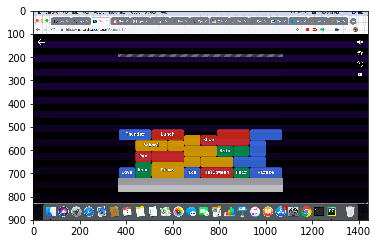

In [15]:
screen = take_screen_shot()
plot_img(screen)

### Crop screen shot

Waiting 5 seconds before screen shot
Please change the browser window to semantris blocks mode


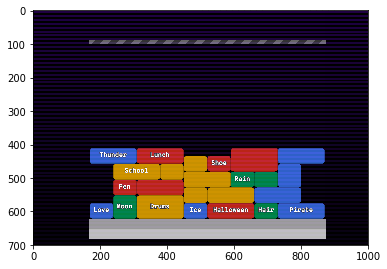

In [16]:
# region: four-integer tuple of the left, top
# width, and height of the region to capture
# for my system the screen is 1440 x 900
screen = take_screen_shot(region=(200, 100, 1000, 700))
plot_img(screen)

### Color palette detection

In [17]:
# cut screen into half (horizontal)
screen_frame = np.array(screen)
screen_frame = screen_frame[int(screen_frame.shape[0] / 2):]

# convert and reshape image format
screen_frame = cv2.cvtColor(screen_frame, cv2.COLOR_RGB2BGR)
screen_frame = cv2.cvtColor(screen_frame, cv2.COLOR_BGR2RGB)
screen_frame = screen_frame.reshape((screen_frame.shape[0] * screen_frame.shape[1],3))

In [18]:
# Collect 8 major colors in the image using KMeans clustering 
from sklearn.cluster import KMeans
clt = KMeans(n_clusters=8)
clt.fit(screen_frame)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

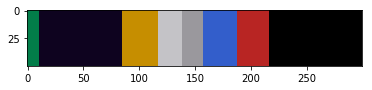

In [19]:
# histogram representing area proportion for each color
hist = find_histogram(clt)
block_colors = []

# plot all 8 colors
bar = plot_colors2(hist, clt.cluster_centers_)
plt.imshow(bar)
plt.show()

# filter out persistent colors from game background
for i, rgb in enumerate(clt.cluster_centers_):
    if not is_blocks_background_color(*rgb, hist[i]):
        block_colors.append(rgb)
        
# plot word block colors
bar = plot_colors2([0.25] * 4, block_colors)

All the 8 (K=8) colors detected in the image.

Based on different characteristics, we will filter out the persistent colors used in the game background. (refer: is_blocks_background_color)

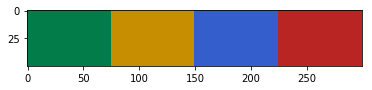

In [20]:
plt.imshow(bar)
plt.show()

Color palette representing 4 major block colors used in the game theme.

### Color tracking

In [22]:
frame = np.array(screen)

# Convert RGB to HSV
hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

# index of block color to track (random among all 4)
block_color_index = random.randint(0, 3)

# define range of a color to track a block color in HSV
block_color_hue = bgr_to_hsv_value(block_colors[block_color_index][::-1])[0]
lower_color_range = np.array([block_color_hue - 10, 50, 50])
upper_color_range = np.array([block_color_hue + 10, 255, 255])

# threshold the HSV image to get only blue colors
mask_color_range = cv2.inRange(hsv, lower_color_range, upper_color_range)

"""
To track multiple colors, you can bitwise-OR
two images with different colors

res = cv2.bitwise_or(res_blue, res_purple)
"""

# Bitwise-AND mask and original images
colored_res = cv2.bitwise_and(frame, frame, mask= mask_color_range)

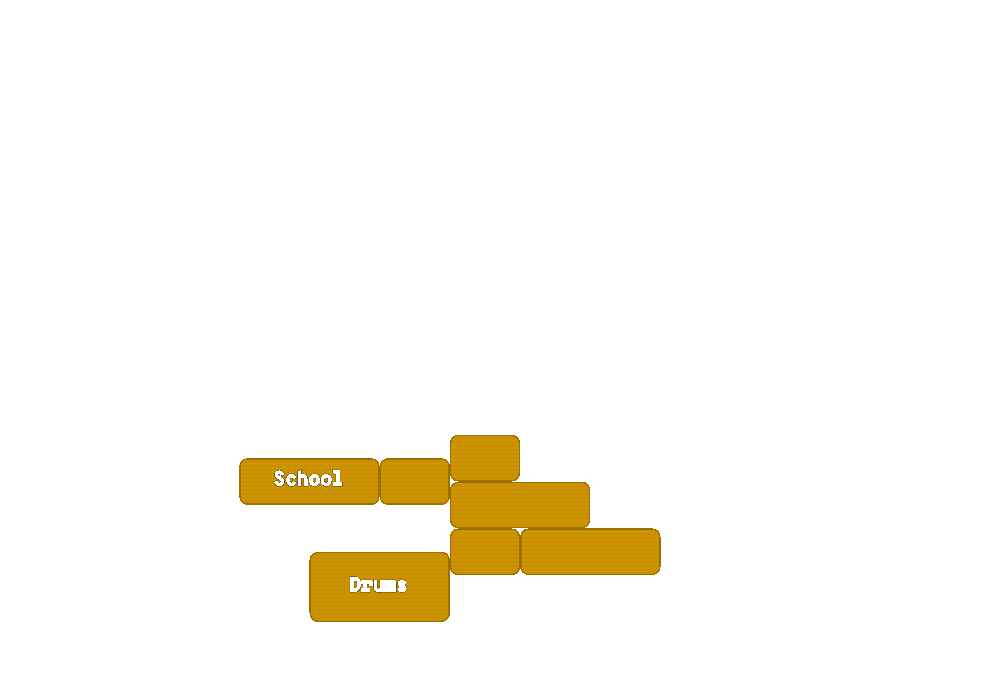

In [23]:
showarray(colored_res)

### Contour detection

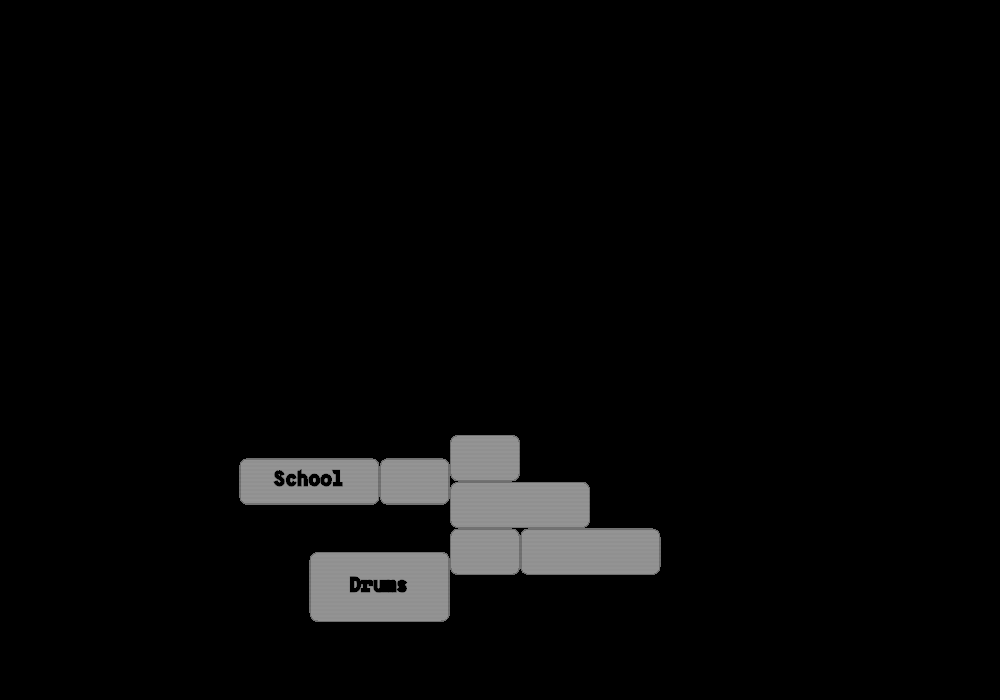

In [24]:
# grayscale conversion
imgray = cv2.cvtColor(colored_res, cv2.COLOR_RGB2GRAY)
showarray(imgray)

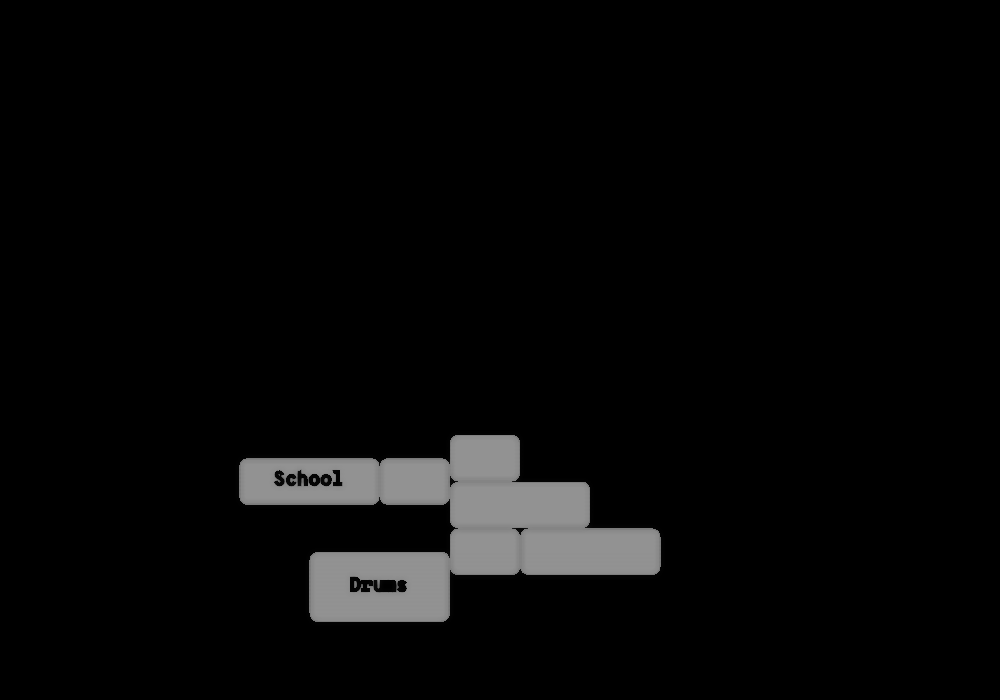

In [25]:
# bilateral filter is effective when you want to
# keep the edges sharp while removing noise
imgray = cv2.bilateralFilter(imgray, 10, 50, 50)
showarray(imgray)

In [26]:
# find contour in gray scale image
_, thresh = cv2.threshold(imgray, 75, 255, 0)
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [27]:
# no of contours found in the image
# word-rectangles attached to each other results in the same contour
len(contours)

1

In [28]:
# finding contour with maximum area
max_area_contour_index = 0
max_area_contour = 0

for i, contour in enumerate(contours):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    imgray = cv2.drawContours(imgray, [box], 0, (0,255,0), 10)
    
    print('perimeter', cv2.arcLength(contour, True))
    area = cv2.contourArea(contour)
    print('area', area)
    
    if cv2.contourArea(contour) >= max_area_contour:
        max_area_contour = area
        max_area_contour_index = i

perimeter 1558.291409611702
area 38289.5


In [29]:
max_area_contour_index, max_area_contour

(0, 38289.5)

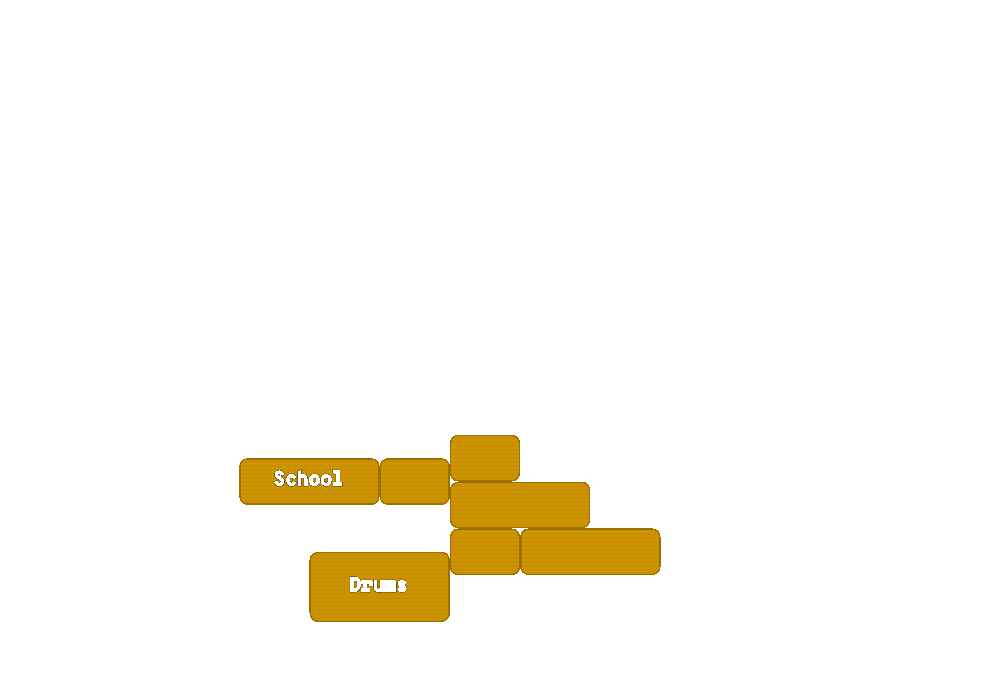

In [30]:
# mask out the image with maximum area contour
mask_contour = np.zeros(imgray.shape[:2], np.uint8)
cv2.drawContours(mask_contour, [contours[max_area_contour_index]],-1, 255, -1)
max_area_contour_image = cv2.bitwise_and(colored_res, colored_res, mask=mask_contour)
showarray(max_area_contour_image)

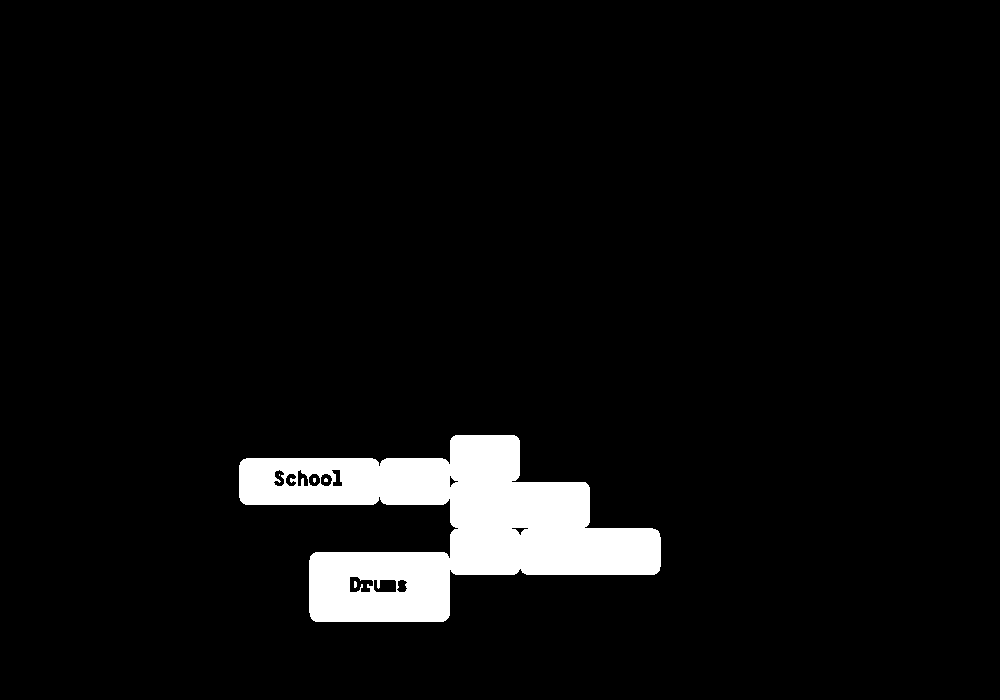

In [31]:
max_area_contour_image_gray = cv2.cvtColor(max_area_contour_image, cv2.COLOR_RGB2GRAY)
(_, max_area_contour_image_bw) = cv2.threshold(
    max_area_contour_image_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU
)
showarray(max_area_contour_image_bw)

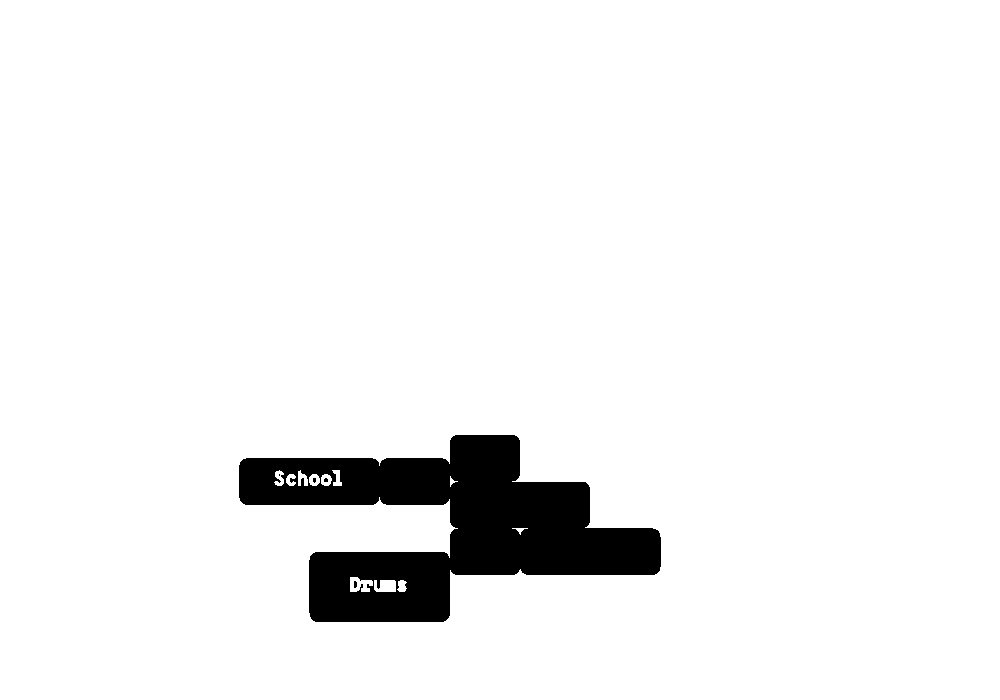

In [32]:
max_area_contour_image_bw_inverted = cv2.bitwise_not(max_area_contour_image_bw)
showarray(max_area_contour_image_bw_inverted)

In [33]:
# Process the contour difference image through OCR/tesseract
pytesseract.image_to_string((max_area_contour_image_bw_inverted - cv2.bitwise_not(mask_contour)))

'School'